In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports & load


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import os
print("Current folder:", os.getcwd())
print("Files here:", os.listdir())


Current folder: E:\EV_Price_Prediction\notebook
Files here: ['.ipynb_checkpoints', 'ev-price-prediction-using-machine-le.ipynb']


#  Quick EDA

In [3]:
import pandas as pd
import zipfile

zip_path = "E:\EV_Price_Prediction\data\Electric_Vehicle_Population_Data.zip"
csv_filename = "Electric_Vehicle_Population_Data.csv"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    with zip_ref.open(csv_filename) as f:
        df = pd.read_csv(f)

print("Data loaded successfully")
df.head()


# Clean column names (important!)
df.columns = df.columns.str.replace(r'[\n\r\t]', '', regex=True).str.strip()

print("Columns in dataset:")
print(df.columns.tolist())
print("\nShape of dataset:", df.shape)

print("\nBasic Info:")
df.info()

print("\nMissing Values:")
print(df.isna().sum())

print("\nSample Data:")
display(df.head())


<>:4: SyntaxWarning: invalid escape sequence '\E'
<>:4: SyntaxWarning: invalid escape sequence '\E'
C:\Users\sriva\AppData\Local\Temp\ipykernel_14904\4116332708.py:4: SyntaxWarning: invalid escape sequence '\E'
  zip_path = "E:\EV_Price_Prediction\data\Electric_Vehicle_Population_Data.zip"


Data loaded successfully
Columns in dataset:
['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP', 'Legislative District', 'DOL Vehicle ID', 'Vehicle Location', 'Electric Utility', '2020 Census Tract']

Shape of dataset: (124716, 17)

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124716 entries, 0 to 124715
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         124716 non-null  object 
 1   County                                             124714 non-null  object 
 2   City                                               124714 non-null  object 
 3   State                                              124716 non-null  object 
 4   Postal C

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EB4L,Yakima,Yakima,WA,98908.0,2020,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,322,0,14.0,127175366,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10
1,5YJ3E1EA7K,San Diego,San Diego,CA,92101.0,2019,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,220,0,NaN,266614659,POINT (-117.16171 32.71568),NaN,6.073005e+09
2,7JRBR0FL9M,Lane,Eugene,OR,97404.0,2021,VOLVO,S60,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,22,0,NaN,144502018,POINT (-123.12802 44.09573),NaN,4.103900e+10
3,5YJXCBE21K,Yakima,Yakima,WA,98908.0,2019,TESLA,MODEL X,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,289,0,14.0,477039944,POINT (-120.56916 46.58514),PACIFICORP,5.307700e+10
4,5UXKT0C5XH,Snohomish,Bothell,WA,98021.0,2017,BMW,X5,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,14,0,1.0,106314946,POINT (-122.18384 47.8031),PUGET SOUND ENERGY INC,5.306105e+10


In [4]:

df[['Model Year','Make','Model','Electric Vehicle Type','Electric Range','Base MSRP']].describe(include='all')
# Check missingness
missing = df[['Model Year','Make','Model','Electric Vehicle Type','Electric Range','Base MSRP']].isnull().sum()
print("Missing counts:\n", missing)
# Value counts for categorical
print("Top Makes:", df['Make'].value_counts().head())


Missing counts:
 Model Year                 0
Make                       0
Model                    181
Electric Vehicle Type      0
Electric Range             0
Base MSRP                  0
dtype: int64
Top Makes: Make
TESLA        57124
NISSAN       12946
CHEVROLET    10836
FORD          6680
BMW           5578
Name: count, dtype: int64


# 3. DATA CLEANING

In [5]:
# Fill numeric NaN with median, categorical with mode
for col in df.select_dtypes(include=[np.number]).columns:
    df[col].fillna(df[col].median(), inplace=True)

for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Drop unnecessary or identifier columns
drop_cols = [
    'VIN (1-10)', 'DOL Vehicle ID', 'Vehicle Location',
    '2020 Census Tract', 'Legislative District', 'Electric Utility'
]
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')


C:\Users\sriva\AppData\Local\Temp\ipykernel_14904\1209143942.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\sriva\AppData\Local\Temp\ipykernel_14904\1209143942.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For examp

#  4. DEFINE FEATURES AND TARGET

In [6]:
target = 'Base MSRP'   # predicting vehicle price
df = df[df[target].notnull()]  # drop rows with missing target

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#  Preprocessing pipeline

In [7]:
# --- FINAL TRAINING PIPELINE ---
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Select columns
num_cols = ['Model Year', 'Electric Range']
cat_cols = [
    'Make', 'Model', 'Electric Vehicle Type',
    'City', 'County', 'Postal Code', 'State',
    'Clean Alternative Fuel Vehicle (CAFV) Eligibility'
]

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# Model pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', RandomForestRegressor(n_estimators=200, random_state=42))
])

# Train pipeline
pipeline.fit(X_train, y_train)

# Evaluate
print("Train R²:", pipeline.score(X_train, y_train))
print("Test R²:", pipeline.score(X_test, y_test))

# Save trained model
import os
os.makedirs("E:\EV_Price_Prediction\model", exist_ok=True)
joblib.dump(pipeline, "E:\EV_Price_Prediction\model\ev_price_model.pkl")

print(" Model saved successfully in E:\EV_Price_Prediction\model\ev_price_model.pkl")


<>:37: SyntaxWarning: invalid escape sequence '\E'
<>:38: SyntaxWarning: invalid escape sequence '\E'
<>:40: SyntaxWarning: invalid escape sequence '\E'
<>:37: SyntaxWarning: invalid escape sequence '\E'
<>:38: SyntaxWarning: invalid escape sequence '\E'
<>:40: SyntaxWarning: invalid escape sequence '\E'
C:\Users\sriva\AppData\Local\Temp\ipykernel_14904\895919558.py:37: SyntaxWarning: invalid escape sequence '\E'
  os.makedirs("E:\EV_Price_Prediction\model", exist_ok=True)
C:\Users\sriva\AppData\Local\Temp\ipykernel_14904\895919558.py:38: SyntaxWarning: invalid escape sequence '\E'
  joblib.dump(pipeline, "E:\EV_Price_Prediction\model\ev_price_model.pkl")
C:\Users\sriva\AppData\Local\Temp\ipykernel_14904\895919558.py:40: SyntaxWarning: invalid escape sequence '\E'
  print(" Model saved successfully in E:\EV_Price_Prediction\model\ev_price_model.pkl")


Train R²: 0.9894071769143454
Test R²: 0.984373026639082
 Model saved successfully in E:\EV_Price_Prediction\model\ev_price_model.pkl


#  Baseline models

In [8]:
print(df.columns.tolist())


['County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range', 'Base MSRP']


In [9]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}


#  Hyperparameter Tuning

In [10]:
print("\n Performing Hyperparameter Tuning...")

# --- Random Forest ---
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [10, 20, None],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(
    rf_pipeline, rf_params, cv=3, n_jobs=-1,
    scoring='r2', verbose=1
)
rf_grid.fit(X_train, y_train)
print(f" Best RF Params: {rf_grid.best_params_}")
print(f" Best RF R² Score: {rf_grid.best_score_:.4f}")

# --- Gradient Boosting ---
gb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

gb_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__max_depth': [3, 5],
    'regressor__subsample': [0.8, 1.0]
}

gb_grid = GridSearchCV(
    gb_pipeline, gb_params, cv=3, n_jobs=-1,
    scoring='r2', verbose=1
)
gb_grid.fit(X_train, y_train)
print(f" Best GB Params: {gb_grid.best_params_}")
print(f" Best GB R² Score: {gb_grid.best_score_:.4f}")



 Performing Hyperparameter Tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
 Best RF Params: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
 Best RF R² Score: 0.9218
Fitting 3 folds for each of 16 candidates, totalling 48 fits
 Best GB Params: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}
 Best GB R² Score: 0.9264


#  Evaluate & save

In [11]:
best_models = {
    "Random Forest (Tuned)": rf_grid.best_estimator_,
    "Gradient Boosting (Tuned)": gb_grid.best_estimator_
}

print("\n Final Evaluation on Test Set")
final_results = {}

for name, model in best_models.items():
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    final_results[name] = {"MAE": mae, "RMSE": rmse, "R²": r2}

final_df = pd.DataFrame(final_results).T
display(final_df)


 Final Evaluation on Test Set


,MAE,RMSE,R²
Random Forest (Tuned),28.111429,1234.524964,0.984079
Gradient Boosting (Tuned),55.824669,1381.369224,0.980066


# BEST MODEL FEATURE IMPORTANCE


Best Tuned Model: Random Forest (Tuned)


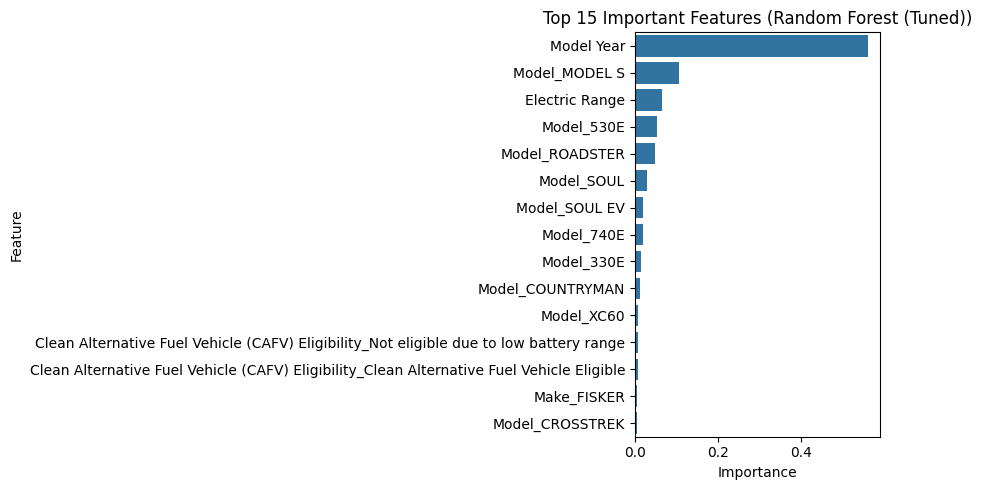

In [12]:
best_model_name = final_df['R²'].idxmax()
print(f"\nBest Tuned Model: {best_model_name}")

best_pipe = best_models[best_model_name]
reg = best_pipe.named_steps['regressor']

# Check if model supports feature importances
if hasattr(reg, "feature_importances_"):
    # Get OneHotEncoder directly from ColumnTransformer
    ohe = best_pipe.named_steps['preprocessor'].transformers_[1][1]
    cat_names = ohe.get_feature_names_out(cat_cols)

    # Combine numeric and categorical feature names
    feature_names = np.concatenate([num_cols, cat_names])
    importances = reg.feature_importances_

    # Create dataframe of top 15 features
    fi = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False).head(15)

    # Plot
    plt.figure(figsize=(9, 5))
    sns.barplot(data=fi, x='Importance', y='Feature')
    plt.title(f"Top 15 Important Features ({best_model_name})")
    plt.tight_layout()
    plt.show()

else:
    print("Feature importances not available for this model.")


In [13]:
import joblib
from pathlib import Path

Path("model").mkdir(parents=True, exist_ok=True)

# Save the trained pipeline (preprocessing + model)
joblib.dump(best_pipe, "model/ev_price_model.pkl")

print(" Model saved at model/ev_price_model.pkl")



 Model saved at model/ev_price_model.pkl
